Available datasets:
	Allosteric_Pyramid_Full_Fall22,
	restart_bad_trajs.sh,
	Allosteric_Pyramid_Partial_Fall22,
	AlloSolidCube_X5_4_12Dec22,
	AlloSolidCube_X5_1_12Dec22,
	AlloSolidCube_X3_Singlet_12Dec22,
	check_traj_sizes.sh,
	NoAlloPyramid_14Oct22,
	AlloPyramid_X4_14Mar23,
	jobinfo.txt,
	AlloSolidCube_X1_12Dec22


Enter simulation name:  Allosteric_Pyramid_Full_Fall22
Input the name of an analysis target (pyramid):  pyramid


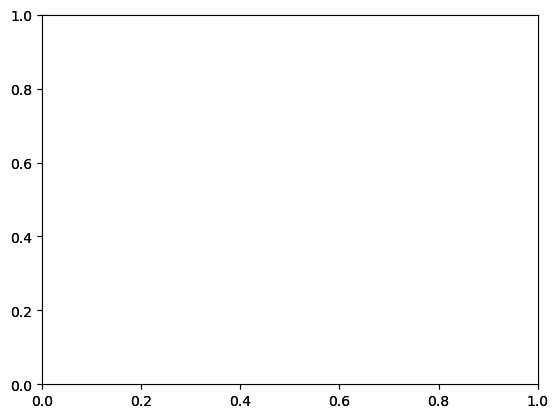

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from analyseClusters import getGraphOverlap
import math

from input_output import *
results_name, results, target_name, target = choose_results_and_target()

In [2]:
eg = "DEFAULT"
nt = 0
temperature = 0.01
duplicate = 0
data_group = results.get_run(eg, duplicate, nt, temperature)
steps_per_timepoint = getVal(data_group.get_path() + os.sep + "last_conf.dat", 't = ')

Result DEFAULT duplicate 0 nt=0 T=0.01 has 821 timepoints.


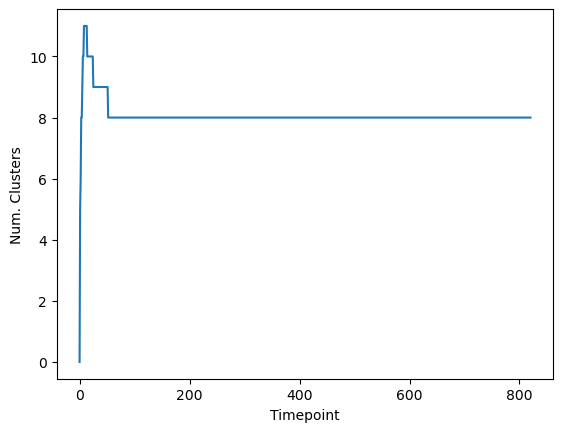

Input a starting timepoint (0 - 821):  0
Input a ending timepoint (0 - 821):  10
How many timepoints? (<10 recommended) 2


In [74]:
print(f"Result {data_group.print_descriptors()} has {data_group.num_timepoints()} timepoints.")
plt.plot(

    [len(data_group.get_cluster_graphs()[pt]) for pt in range(data_group.num_timepoints())]    
)
plt.xlabel("Timepoint")
plt.ylabel("Num. Clusters")
plt.show()
tmin = int(input(f"Input a starting timepoint (0 - {data_group.num_timepoints()}): "))
tmax = int(input(f"Input a ending timepoint (0 - {data_group.num_timepoints()}): "))
assert tmax > tmin
num_timepoints = int(input(f"How many timepoints? (<10 recommended)"))
trange = [int(i) for i in np.linspace(tmin, tmax, num_timepoints + 1, dtype=int)]

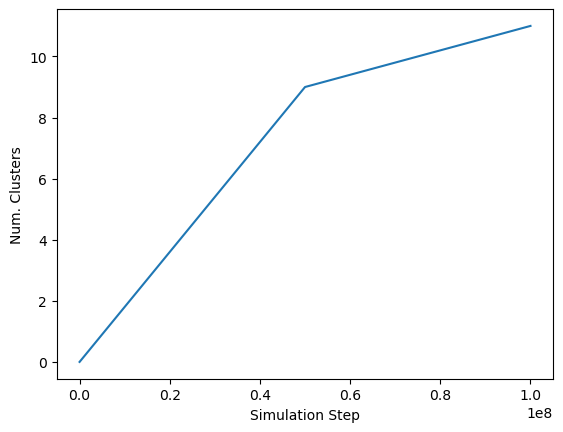

In [75]:
tgraphs = [data_group.get_cluster_graphs()[t] for t in trange]
ttimesteps = np.array(trange) * OXDNA_PRINT_CLUSTERS_EVERY
plt.plot(
    ttimesteps,
    [len(pt) for pt in tgraphs]    
)
plt.xlabel("Simulation Step")
plt.ylabel("Num. Clusters")
plt.show()

In [ ]:
G = nx.DiGraph()
# construct position dict
plt.figure(figsize=(
    len(tgraphs) * 4,
    max(len(gs) for gs in tgraphs) * 4
    )
)
nwmax = 0
for x, tg in enumerate (tgraphs):
    if len(tg) > 0:
        dy = h / len(tg)
        for y, g in enumerate(tg):
            pos[g] = (x * 100 ,y*500)
            minipos = nx.spring_layout(g, 
                                       center=pos[g],
                                       scale=6,
                                       k=10/math.sqrt(target["graph"].size()),
                                       seed=42,
                                      iterations=100)
            nx.draw_networkx(g,
                             pos=minipos,
                             node_color=[
                                 selectColor(data_group.particle_identities[n]) for n in g.nodes()
                             ],
                             node_size=150,
                             font_size=6)
            G.add_node(g)
        dymin = min(dymin, dy)

for x,tg in enumerate(tgraphs[:-1]):
    for i, g1 in enumerate(tg):
        for j, g2 in enumerate(tgraphs[x+1]):
            if set(g1).intersection(set(g2)):
                G.add_edge(g1, g2)

nodes = nx.draw_networkx_nodes(G, 
                       pos=pos,
                      node_color="#0f0f0f00",
                      edgecolors="black",
                      node_size=8e3)
edges = nx.draw_networkx_edges(G, pos, arrows="->")
# nx.draw_networkx(G, pos)

In [173]:
LABELS=False

In [169]:
def same_id(n1, n2):
    return n1['id'] == n2['id']

class TreeNode:
    def __init__(self, G, parent=None):
        if parent is not None:
            parent.add_child(self)
        self.graph = G
        nx.set_node_attributes(self.graph, {n: n for n in self.graph}, name="id")
        self.children = []
        self.x = -1
        self.y = -1
        self.product_lvl = getGraphOverlap(self.graph, target['graph'], 0, False)
        
    def add_child(self, child):
        self.children.append(child)
    
    def get_gen_0_size(self):
        if len(self.children) == 0:
            return 1
        else:
            return sum([n.get_gen_0_size() for n in self.children])
        
        
graphs = [[] for _ in trange]
i = len(trange) - 1
while i > -1:
    t = trange[i]
    if i == len(trange) - 1:
        graphs[i] = [TreeNode(G) for G in data_group.cluster_graphs[t]]
    else:
        for G in data_group.cluster_graphs[t]:
            nx.set_node_attributes(G, {n: n for n in G}, name="id")
            for N in graphs[i + 1]:
                g1 = nx.line_graph(G)
                g2 = nx.line_graph(N.graph)
                if isomorphism.GraphMatcher(
                            G, N.graph,
                            node_match=same_id
                        ).subgraph_is_isomorphic():
                    graphs[i].append(TreeNode(G, N))
                    break;
    i -= 1

In [185]:
def drawGraph(G, x, y, axes):
    colors = [mpl.colors.hsv_to_rgb(((((137.508 * data_group.particle_identities[c])  % 360) / 360), .5,.65)) for c in G]
    nx.draw_networkx(G,
                     with_labels=LABELS,
                     ax=axs[y,x],
                     font_weight='bold', 
                     node_color=colors,
                     font_size=8,
                     node_size=150)

/tmp/ipykernel_45400/228014574.py:35: MatplotlibDeprecationWarning: Passing the axesA parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  cp = mpl.patches.ConnectionPatch((1, 0.5), (0, 0.5),


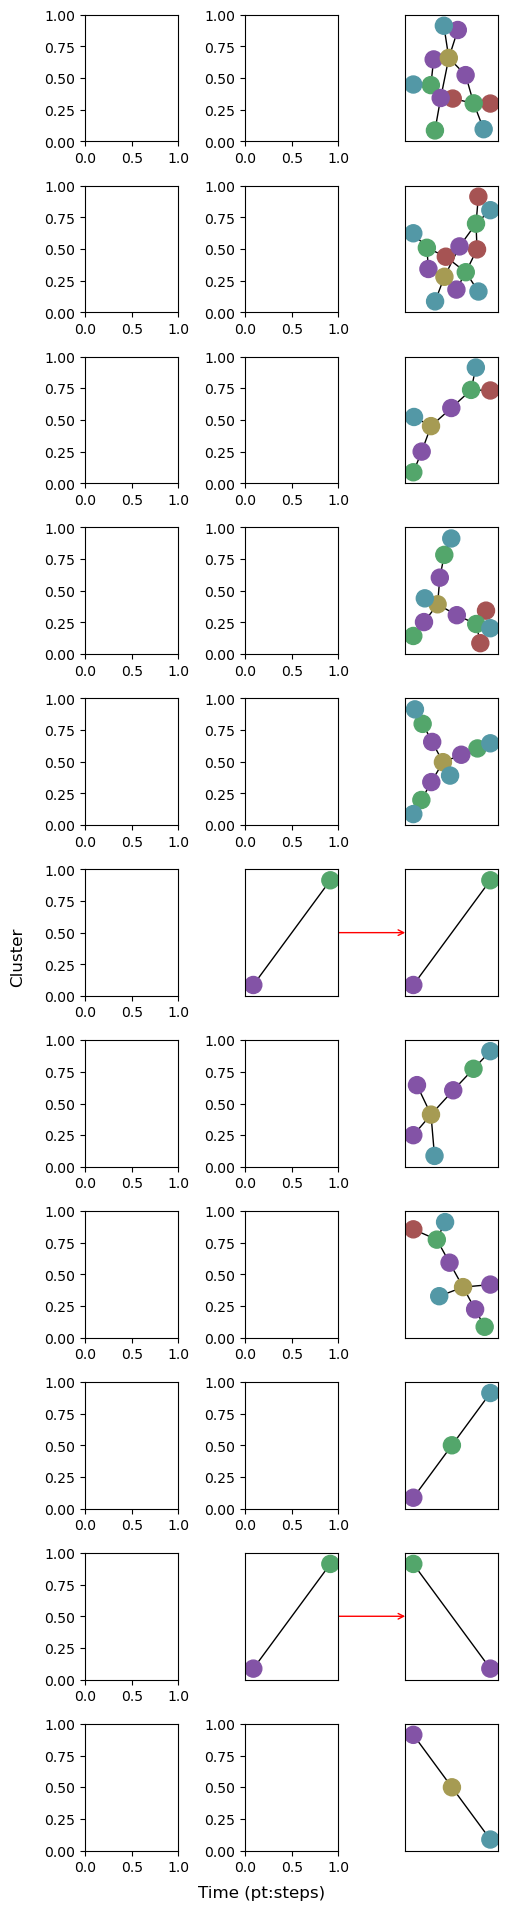

In [187]:
xs = len(trange)
ys = sum([n.get_gen_0_size() for n in graphs[len(graphs) - 1]])
fig, axs = plt.subplots(ys, xs)
fig.set_figheight(1.75 * ys)
fig.set_figwidth(1.75 * xs)
fig.supxlabel("Time (pt:steps)")
fig.supylabel("Cluster")
fig.tight_layout()
nextGen = None
x = xs - 1
# process backwards
while (x > -1):
    y = 0
    if nextGen is None:
        gs = graphs[len(graphs) - 1]
        for n in gs: 
            footprint = n.get_gen_0_size()
            drawGraph(n.graph, x, y + int(footprint / 2), axs)
            n.x = x
            n.y = y + int(footprint / 2)
            y += footprint
        nextGen = gs
    else:
        gss = nextGen
        nextGen = []
        # loop each graph in the following generation
        for gs in gss:
            # loop each child node of the graph (from following generation)
            for n in gs.children:
                footprint = n.get_gen_0_size()
                ypos = gs.y + int (footprint / 2)
                drawGraph(n.graph, x, ypos, axs)
                if ypos == 0:
                    axs.title("TITLE")
                cp = mpl.patches.ConnectionPatch((1, 0.5), (0, 0.5), 
                                                 "axes fraction", "axes fraction",
                                                 axs[ypos, x], axs[gs.y, gs.x],
                                                color="red", arrowstyle="->")
                axs[1, 1].add_artist(cp)
                n.x = x
                n.y = ypos     
                nextGen.append(n)
    x -= 1

In [188]:
timepoint = int(input(f"Select a timepoint between 0 and {len(data_group.cluster_graphs)} (* {steps_per_timepoint}): "))

Select a timepoint between 0 and 821 (* 8200000000.0):  800


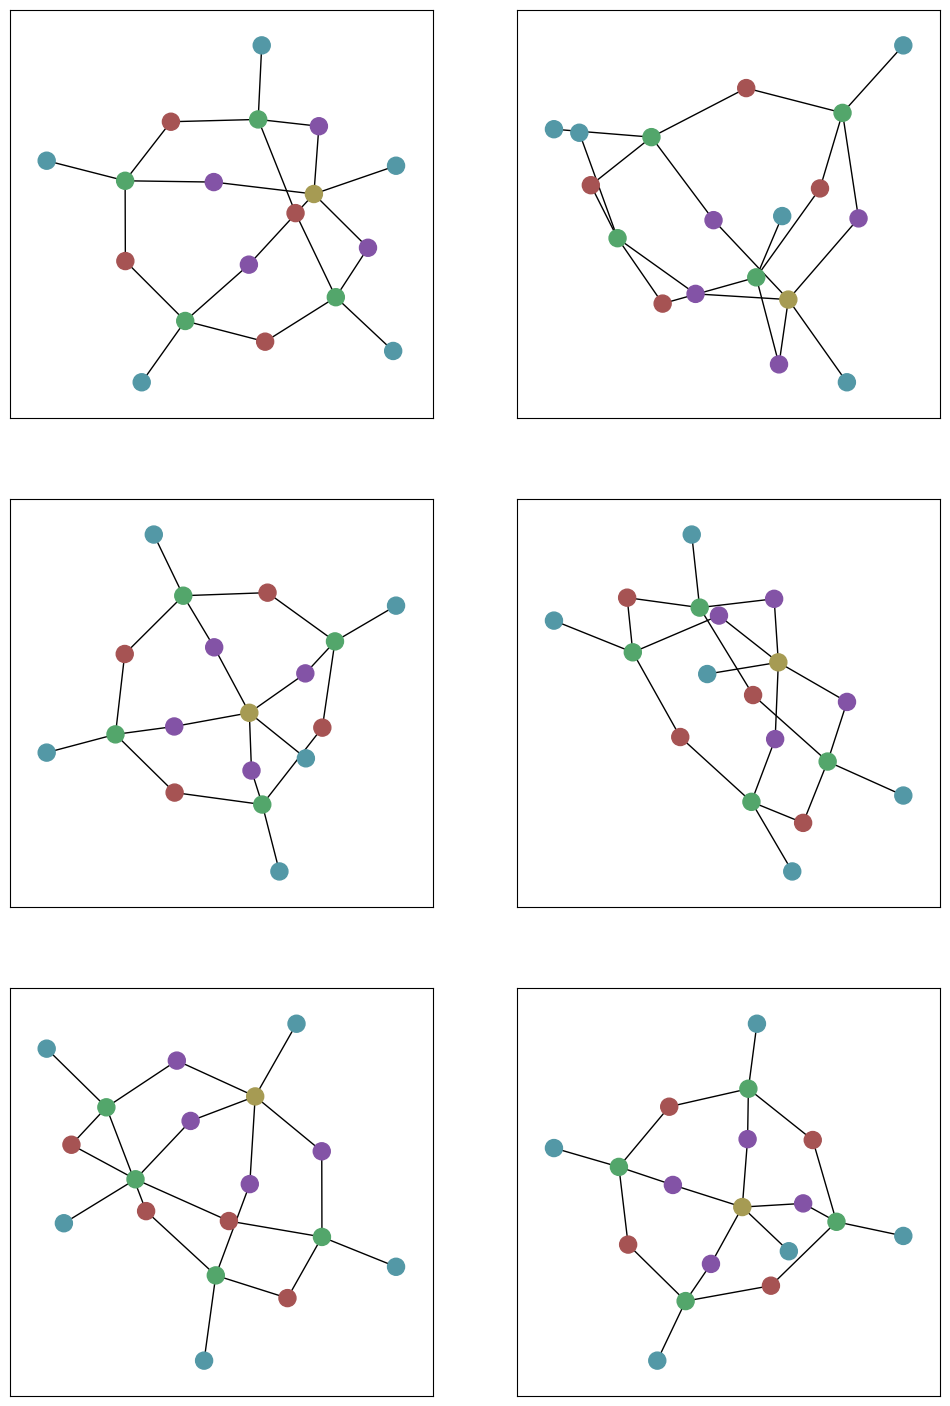

In [218]:
# data_group.cluster_graphs
# data_group.particle_identities
graphs = data_group.get_cluster_graphs()[timepoint]
xs = math.floor(math.sqrt(len(graphs)))
ys = math.ceil(math.sqrt(len(graphs)))
fig, axs = plt.subplots(ys, xs, figsize=(6*xs, 6*ys))
for x in range(xs):
    for y in range(ys):
        i = y * xs + x
        nx.draw_networkx(graphs[i],
                     pos=nx.spring_layout(graphs[i], seed=24),
                     with_labels=LABELS,
                     ax=axs[y,x],
                     font_weight='bold', 
                     node_color=[
                                 mpl.colors.hsv_to_rgb(((((137.508 * data_group.particle_identities[n])  % 360) / 360), .5,.65)) for n in graphs[i].nodes()
                             ],
                     font_size=8,
                     node_size=150)

In [211]:
[data_group.particle_identities[n] for n in graphs[0].nodes()]

[0, 1, 1, 0, 1, 0, 1, 0, 4, 2, 2, 4, 4, 2, 4, 2, 3, 4]